In [1]:
get_ipython().system('pip install opencv-python')
get_ipython().system('pip install scikit-learn pillow tqdm')
get_ipython().system('pip install torch torchvision numpy matplotlib')
get_ipython().system('pip install tqdm')
get_ipython().system('pip install Augmentor')
get_ipython().system('pip install tensorflow')
get_ipython().system('pip install faiss-cpu')
get_ipython().system('pip install pillow')

In [3]:
import sys
import os

    
import cv2   
import torch
import PIL
import pandas as pd
import numpy as np
import Augmentor
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import tensorflow as tf
import torch.nn as nn
import torch.optim as optim
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.version.cuda)
print(f"Number of GPUs available: {torch.cuda.device_count()}")
print(f"GPU Name: {torch.cuda.get_device_name(0)}")

cuda:0
12.1
Number of GPUs available: 1
GPU Name: NVIDIA GeForce RTX 4070


In [5]:
# Load data set from local folder by class
def load_images(dataset_path):
    data = []
    for class_folder in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_folder)
        if os.path.isdir(class_path):
            for img_file in glob(f"{class_path}/*.jpg"):  # Adjust the file extension if needed
                data.append({"file_path": img_file, "class": class_folder})
    df = pd.DataFrame(data)
    return df

# Apply preprocessing to each image
def preprocess_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB if needed
    return image

# Create dataframe with ground truth
dataset_path = "/home/alan/Documents/SelfReferencing_CNN_Project/ChestXrays/Curated Dataset for COVID-19 Posterior-Anterior Chest Radiography Images (X-Rays)/Curated X-Ray Dataset"
df = load_images(dataset_path)
print(df.tail())

# Add images to dataframe
df['image'] = df['file_path'].apply(preprocess_image)
print(df.head())


                                              file_path     class
9204  /home/alan/Documents/SelfReferencing_CNN_Proje...  COVID-19
9205  /home/alan/Documents/SelfReferencing_CNN_Proje...  COVID-19
9206  /home/alan/Documents/SelfReferencing_CNN_Proje...  COVID-19
9207  /home/alan/Documents/SelfReferencing_CNN_Proje...  COVID-19
9208  /home/alan/Documents/SelfReferencing_CNN_Proje...  COVID-19
                                           file_path                class  \
0  /home/alan/Documents/SelfReferencing_CNN_Proje...  Pneumonia-Bacterial   
1  /home/alan/Documents/SelfReferencing_CNN_Proje...  Pneumonia-Bacterial   
2  /home/alan/Documents/SelfReferencing_CNN_Proje...  Pneumonia-Bacterial   
3  /home/alan/Documents/SelfReferencing_CNN_Proje...  Pneumonia-Bacterial   
4  /home/alan/Documents/SelfReferencing_CNN_Proje...  Pneumonia-Bacterial   

                                               image  
0  [[[21, 21, 21], [17, 17, 17], [22, 22, 22], [2...  
1  [[[140, 140, 140], [140, 140

In [7]:
class_distribution = df['class'].value_counts()
print(class_distribution)

# Get the size of the smallest class
min_class_count = class_distribution.min()

# Function to undersample a class to the minimum class count
def undersample_class(df, class_name, n_samples):
    return df[df['class'] == class_name].sample(n_samples, random_state=42)

# Create a balanced DataFrame by undersampling each class
balanced_df = pd.concat([
    undersample_class(df, class_name, min_class_count)
    for class_name in class_distribution.index
])

# Shuffle the balanced DataFrame
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the new class distribution
balanced_class_distribution = balanced_df['class'].value_counts()
print(balanced_class_distribution)

class
Normal                 3271
Pneumonia-Bacterial    3001
Pneumonia-Viral        1656
COVID-19               1281
Name: count, dtype: int64
class
Normal                 1281
Pneumonia-Bacterial    1281
COVID-19               1281
Pneumonia-Viral        1281
Name: count, dtype: int64


In [8]:
# Convert images to numpy array
X = np.stack(balanced_df['image'].values)

# Convert class labels to one-hot encoding
y = pd.get_dummies(balanced_df['class']).values

# Normalize pixel values between 0 and 1
X = X / 255.0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the shapes of the resulting arrays
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4099, 224, 224, 3)
y_train shape: (4099, 4)
X_test shape: (1025, 224, 224, 3)
y_test shape: (1025, 4)


In [14]:
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [10]:
# Prepare the dataset
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, y_train.shape[1])
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, torch.max(labels, 1)[1])
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Save the model weights
os.makedirs('model_weights', exist_ok=True)
torch.save(model.state_dict(), 'model_weights/resnet50_weights.pth')

# Evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(torch.max(labels, 1)[1].cpu().numpy())
    return all_preds, all_labels

# Evaluate on training and testing sets
train_preds, train_labels = evaluate_model(model, train_loader)
test_preds, test_labels = evaluate_model(model, test_loader)

# Calculate metrics
train_accuracy = accuracy_score(train_labels, train_preds)
train_precision = precision_score(train_labels, train_preds, average='weighted')
train_recall = recall_score(train_labels, train_preds, average='weighted')
train_f1 = f1_score(train_labels, train_preds, average='weighted')

test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average='weighted')
test_recall = recall_score(test_labels, test_preds, average='weighted')
test_f1 = f1_score(test_labels, test_preds, average='weighted')

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train Recall: {train_recall:.4f}")
print(f"Train F1-Score: {train_f1:.4f}")

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

/home/alan/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alan/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/alan/snap/jupyterlab-desktop/common/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:14<00:00, 7.01MB/s]


Epoch [1/40], Loss: 0.5914
Epoch [2/40], Loss: 0.4759
Epoch [3/40], Loss: 0.4137
Epoch [4/40], Loss: 0.3883
Epoch [5/40], Loss: 0.3441
Epoch [6/40], Loss: 0.3405
Epoch [7/40], Loss: 0.3226
Epoch [8/40], Loss: 0.2886
Epoch [9/40], Loss: 0.3143
Epoch [10/40], Loss: 0.2337
Epoch [11/40], Loss: 0.2539
Epoch [12/40], Loss: 0.1740
Epoch [13/40], Loss: 0.1293
Epoch [14/40], Loss: 0.2376
Epoch [15/40], Loss: 0.1122
Epoch [16/40], Loss: 0.2387
Epoch [17/40], Loss: 0.0692
Epoch [18/40], Loss: 0.0726
Epoch [19/40], Loss: 0.1401
Epoch [20/40], Loss: 0.0655
Epoch [21/40], Loss: 0.0248
Epoch [22/40], Loss: 0.0370
Epoch [23/40], Loss: 0.1768
Epoch [24/40], Loss: 0.1250
Epoch [25/40], Loss: 0.1555
Epoch [26/40], Loss: 0.0877
Epoch [27/40], Loss: 0.0339
Epoch [28/40], Loss: 0.0547
Epoch [29/40], Loss: 0.1074
Epoch [30/40], Loss: 0.2148
Epoch [31/40], Loss: 0.0308
Epoch [32/40], Loss: 0.0265
Epoch [33/40], Loss: 0.0129
Epoch [34/40], Loss: 0.0733
Epoch [35/40], Loss: 0.0249
Epoch [36/40], Loss: 0.0133
E

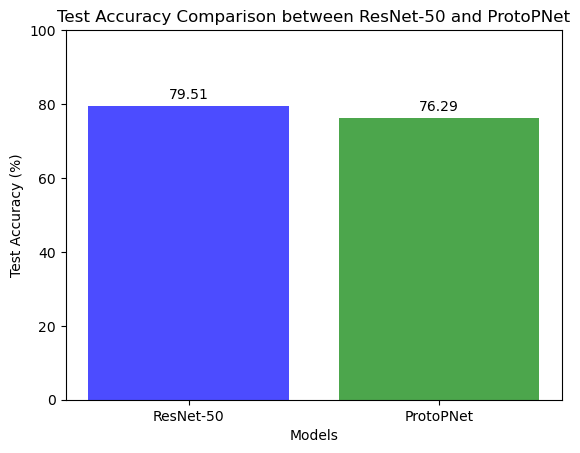

In [12]:
import matplotlib.pyplot as plt

# Test accuracy values
models = ['ResNet-50', 'ProtoPNet']
test_accuracies = [79.51, 76.292]

# Create a bar plot
fig, ax = plt.subplots()

# Bar positions
bar_positions = range(len(models))

# Plot bars
bars = ax.bar(bar_positions, test_accuracies, align='center', alpha=0.7, color=['blue', 'green'])

# Labeling the plot
ax.set_xlabel('Models')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Test Accuracy Comparison between ResNet-50 and ProtoPNet')
ax.set_xticks(bar_positions)
ax.set_xticklabels(models)
ax.set_ylim(0, 100)

# Adding data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom')

# Show the plot
plt.show()



In [25]:
# Define the path to custom weights
weights_path = '/home/alan/Documents/SelfReferencing_CNN_Project/JupyterNotebooks/model_weights/resnet50_weights.pth'

# Load the pre-trained ResNet-50 model
model = models.resnet50(pretrained=False)

# Modify the final fully connected layer to match the number of classes
num_classes = 4  
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Load the state_dict
model.load_state_dict(torch.load(weights_path))

# Set the model to evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print('Model loaded with weights successfully')

Model loaded with weights successfully


In [34]:
# Extract Features Using the ResNet-50 Model
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define your dataset and dataloader
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder('/home/alan/Documents/SelfReferencing_CNN_Project/datasets/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Remove the fully connected layer to get features from the penultimate layer
model = nn.Sequential(*list(model.children())[:-1])
model = model.to(device)
model.eval()

# Initialize FAISS index
import faiss
d = 2048  # Dimension of the features (for ResNet-50 penultimate layer)
index = faiss.IndexFlatL2(d)

# Extract features and add to FAISS index
for inputs, labels in train_loader:
    inputs = inputs.to(device)
    with torch.no_grad():
        features = model(inputs).squeeze(-1).squeeze(-1).cpu().numpy()
    index.add(features)

print('Features added to FAISS index successfully')

# Save the FAISS index to a file
faiss.write_index(index, '/home/alan/Documents/SelfReferencing_CNN_Project/faiss_index.bin')



Features added to FAISS index successfully


Predicted Class: 0
Distances: [   3.5866816    4.308184     4.497851  ...  833.2844     833.3259
 1168.951    ]
Indices: [ 479  615   37 ... 1072 1895 2740]
Inference and feature extraction complete.


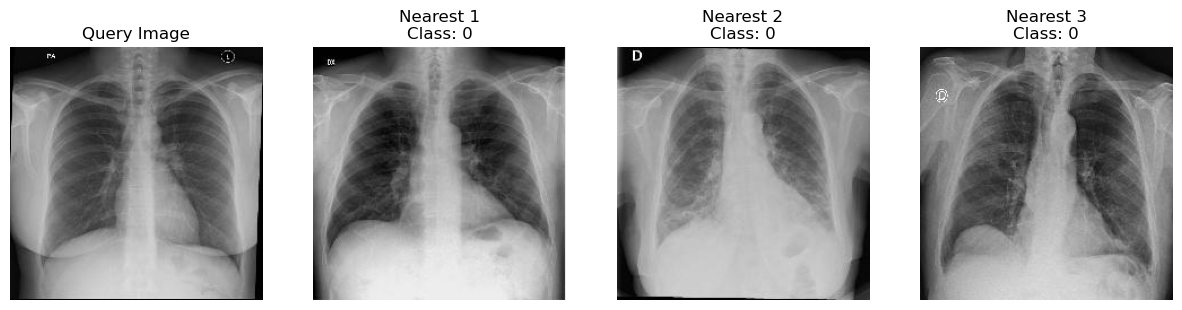

In [55]:
from PIL import Image

# Define the path to your custom weights
#weights_path = '/home/alan/Documents/SelfReferencing_CNN_Project/JupyterNotebooks/model_weights/resnet50_weights.pth'

# Load the pre-trained ResNet-50 model
model = models.resnet50(pretrained=False)

# Modify the final fully connected layer to match the number of classes
num_classes = 4  # Change this to match your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Load the state_dict
model.load_state_dict(torch.load(weights_path))

# Set the model to evaluation mode
model.eval()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define transformations for the input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load an image for inference
image_path = '/home/alan/Documents/SelfReferencing_CNN_Project/datasets/test/COVID-19/image_55.jpg/'
image = Image.open(image_path).convert('RGB')
image = transform(image).unsqueeze(0)  # Add batch dimension

# Perform inference to get classification results
image = image.to(device)
with torch.no_grad():
    logits = model(image)
    _, predicted_class = torch.max(logits, 1)

print(f'Predicted Class: {predicted_class.item()}')

# Remove the fully connected layer to get features from the penultimate layer
feature_extractor = nn.Sequential(*list(model.children())[:-1])
feature_extractor = feature_extractor.to(device)

# Extract features from the image
with torch.no_grad():
    features = feature_extractor(image).squeeze(-1).squeeze(-1).cpu().numpy()

index = faiss.read_index('/home/alan/Documents/SelfReferencing_CNN_Project/faiss_index.bin')

# Ensure the index has been populated
if index.ntotal == 0:
    raise ValueError("FAISS index is empty")

# Query the FAISS index with the extracted features
D, I = index.search(features, k=index.ntotal)  # `D` is the distance array, `I` is the index array

D = D.flatten()
I = I.flatten()

print(f'Distances: {D}')
print(f'Indices: {I}')

# Optional: Retrieve corresponding training samples based on indices
# Assuming `train_dataset` is the dataset used to create the FAISS index
nearest_samples = [train_dataset[i] for i in I.flatten()]

print('Inference and feature extraction complete.')

# Display the query image and the first 3 nearest images
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

image = image.squeeze(0).cpu()
image = transforms.ToPILImage()(image)
# Display the query image
axes[0].imshow(image)
axes[0].set_title("Query Image")
axes[0].axis('off')

# Load the training dataset to access images
train_dataset = datasets.ImageFolder('/home/alan/Documents/SelfReferencing_CNN_Project/datasets/train', transform=transform)

# Display the nearest images and their predicted classes
for i in range(3):
    nearest_image_index = I[i]
    nearest_image_path = train_dataset.imgs[nearest_image_index][0]
    nearest_image_label = train_dataset.imgs[nearest_image_index][1]
    
    nearest_image = Image.open(nearest_image_path).convert('RGB')
    axes[i + 1].imshow(nearest_image)
    axes[i + 1].set_title(f"Nearest {i + 1}\nClass: {nearest_image_label}")
    axes[i + 1].axis('off')

plt.show()